In [1]:
import numpy as np
import cv2 as cv

* normaliseren per dataset (z-score vs 0-1)
* normaliseren per plaatje (z-score vs 0-1)
* converteren naar grijswaarden plaatje
* histogram test-set converteren naar histogram training set
* gabor filter
* normaliseren per cluster
* T-SNE met feature vectors

In [2]:
from ProjectPaths import ProjectPaths

In [3]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [4]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))
images[0].shape

(75, 75, 3)

In [5]:
def avg_image(image):
    avg_kernel = np.ones((3,3), dtype=np.float32)
    avg_kernel /= 9
    return cv.filter2D(image, -1, avg_kernel).reshape(image.shape)

In [6]:
avg_image(images[0]).shape

(75, 75, 3)

In [7]:
def window_locations(r = 2, n_channels = 3):
    x = [-r, 0, r]
    y = [-r, 0, r]
    mask = np.zeros((1+2*r,1+2*r))
    
    for xc in x:
        for yc in y:
            mask[r + yc, r + xc] = 1.0
    return np.tile(mask,(n_channels,1,1)).T
    
window_mask = window_locations()

In [8]:
def number_of_channels(image):
    if image.ndim == 3:
        return image.shape[2]
    return 1

In [9]:
def extract_features(image, r=2):
    #grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    
    kernel = window_locations(r, number_of_channels(image))
    (kH, kW) = kernel.shape[:2]

    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW, 9 *  number_of_channels(image)), dtype="float32")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual selection by taking the
            # element-wise multiplicate between the ROI and
            # the kernel
            k = (roi * kernel)

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad, :] = k[np.nonzero(kernel)]
    
    # return the output image
    return output

In [10]:
from scipy import ndimage

def std_image(image):
    average = avg_image(image)
    x2_min_avg = (image - average) * (image - average);
    avg_kernel_3d = np.ones((3, 3, number_of_channels(image)), dtype=np.float32)
    avg_kernel_3d /= 9
    conv_image = ndimage.convolve(x2_min_avg, avg_kernel_3d, np.float32) 
    return np.sqrt(conv_image)

In [11]:
def normalize_image(image):
    return (image - image.min(axis=(0,1))) / (image.max(axis=(0,1)) - image.min(axis=(0,1)))
#def normalize_image(image):
#    return (image - image.min()) / (image.max() - image.min())


In [12]:
im_std = images[0]
std = std_image(im_std)
import matplotlib.pyplot as plt
%matplotlib inline

std.dtype

dtype('float32')

In [13]:
def get_features(image):
    avg = avg_image(image)
    std = std_image(image)
    
    avg_output2 = extract_features(avg)
    std_output2 = extract_features(std)
    
    avg_output4 = extract_features(avg, 4)
    std_output4 = extract_features(std, 4)
    return np.concatenate((avg_output2, std_output2, avg_output4, std_output4), axis=2)

In [14]:
def get_features_for(images):
    feature_list = []
    for image in images:
        feature_list.append(get_features(image))
    return np.array(feature_list)

In [15]:
X = get_features_for(images)
X.shape

(120, 75, 75, 108)

In [16]:
pixel_features = X.reshape(120*75*75, 108)
pixel_features.shape

(675000, 108)

In [17]:
pixel_masks = mask_images.reshape(120*75*75)
pixel_masks.shape

(675000,)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixel_features, pixel_masks, test_size = 0.20)

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tim/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
clf.feature_importances_

array([0.03432865, 0.00496871, 0.00922838, 0.02784767, 0.02847469,
       0.02535285, 0.00791269, 0.00951823, 0.02678314, 0.02985564,
       0.00285198, 0.00547518, 0.07518405, 0.01149558, 0.0393226 ,
       0.06008508, 0.00495366, 0.02956441, 0.02689175, 0.00266891,
       0.00628452, 0.00750082, 0.00405264, 0.00534424, 0.01193072,
       0.00261146, 0.00698698, 0.00363248, 0.00399014, 0.00265272,
       0.00513617, 0.00360591, 0.00394446, 0.00331514, 0.00308732,
       0.0039094 , 0.0031946 , 0.00301361, 0.00303022, 0.00423837,
       0.00331858, 0.00393413, 0.00283391, 0.00270752, 0.00223081,
       0.00303975, 0.00225537, 0.00306891, 0.00252382, 0.00209322,
       0.00411728, 0.00388626, 0.00256879, 0.00466283, 0.00923069,
       0.0062474 , 0.00564402, 0.00636687, 0.01213819, 0.04501372,
       0.0071531 , 0.0095615 , 0.02669499, 0.00706095, 0.00330858,
       0.00432336, 0.03678783, 0.00661727, 0.01155447, 0.0065028 ,
       0.00472619, 0.03312473, 0.00542973, 0.00354649, 0.00428

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [22]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     91823
         255       0.96      0.94      0.95     43177

   micro avg       0.97      0.97      0.97    135000
   macro avg       0.96      0.96      0.96    135000
weighted avg       0.97      0.97      0.97    135000

accuracy=0.9666962962962963
[[90052  1771]
 [ 2725 40452]]


In [23]:
im_features = get_features_for([images[-1]])
im_features = im_features.reshape(75*75, 108)

In [24]:
im_pred = clf.predict(im_features)
im_pred.shape

(5625,)

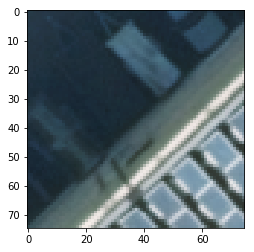

In [26]:
plt.imshow(images[-1][:,:,::-1])

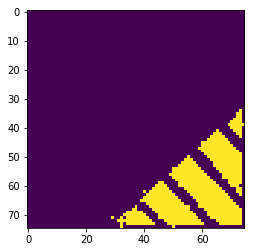

In [25]:
prediction_image = im_pred.reshape(75, 75)
plt.imshow(prediction_image)

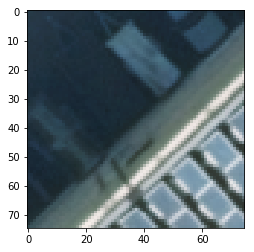

In [27]:
plt.imshow(images[-1][:,:,::-1])

In [28]:
from ProjectPaths import ProjectPaths
from Datasets import Datasets


ProjectPaths.instance()
ac_dataset = Datasets.datasets()["AcMüDüHo"]
train = ac_dataset[0].images

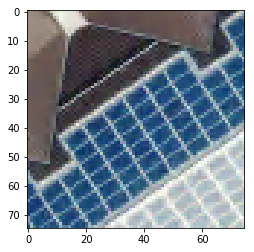

In [29]:
plt.imshow(train[8][:,:,::-1])

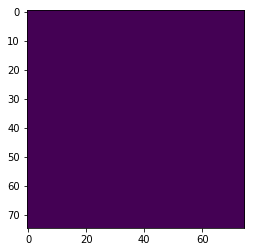

In [30]:
im_features2 = get_features_for([train[8]])
im_features2 = im_features2.reshape(75*75, 108)

im_pred = clf.predict(im_features2)
prediction_image = im_pred.reshape(75, 75)

plt.imshow(prediction_image)

# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

/home/tim/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

In [ ]:
accuracy_score(y_test, predictions)

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
plt.imshow(train[8][:,:,::-1])

In [ ]:
im_features3 = get_features_for([train[8]])
im_features3 = im_features3.reshape(75*75, 108)

im_pred = clf.predict(im_features3)
prediction_image = im_pred.reshape(75, 75)

plt.imshow(normalize_image(prediction_image))

# PCA

In [ ]:
import math

def reorderMatrix(u):
    c1 = np.array([1/3 * math.sqrt(3) for _ in range(3)])
    c2 = np.array([1, -1, -1] * c1)
    c3 = np.array([0, -1/2 * math.sqrt(2), 1/2 * math.sqrt(2)])
    v1 = u.dot(c2)
    i1 = np.argmax(v1)
    v2 = u.dot(c3)
    i2 = np.argmax(v2)
    if i1 == 2 and i2 == 1:
        temp = u[i1]
        u[i1] =  u[i2]
        u[i2] = temp
    return u

def flattenImage(rgbImage):
    return rgbImage.reshape(rgbImage.shape[0] * rgbImage.shape[1], 3)

def imageMean(image):
    return (1 / image.size) * np.sum(image)

def centerImage(image):
    return image - imageMean(image)

def imageCovariance(image1, image2):
    return (1 / image1.size) * np.dot(centerImage(image1).ravel(), centerImage(image2).ravel())

def rgbImageCovarianceMatrix(rgbImage):
    covarianceMatrix = np.zeros([3,3])
    for r in range(3):
        for c in range (3):
            covariance = imageCovariance(rgbImage[:,:,r], rgbImage[:,:,c])
            covarianceMatrix[r, c] = covariance
            covarianceMatrix[c, r] = covariance
    return covarianceMatrix

def pca(rgbImage):
    covarianceMatrix = rgbImageCovarianceMatrix(rgbImage)
    return np.linalg.svd(covarianceMatrix)

def pcaTransform(rgbImage):
    u,s,v = pca(rgbImage)
    imageVector = flattenImage(rgbImage)
    transposedVector = imageVector.dot(reorderMatrix(u))
    return transposedVector.reshape(rgbImage.shape)

In [ ]:
pca_image = pcaTransform(images[0])

_, ax = plt.subplots(1,4,figsize=(14,14))
ax[0].imshow(images[0])
ax[1].imshow(normalize_image(pca_image)[:,:,0])
ax[2].imshow(normalize_image(pca_image)[:,:,1])
ax[3].imshow(normalize_image(pca_image)[:,:,2])

In [ ]:
pca_images = np.array([pcaTransform(image) for image in images])
pca_images.shape

In [ ]:
pca_features = get_features_for(pca_images)
pca_pixel_features = pca_features.reshape(120*75*75, 108)
pca_pixel_features.shape

In [ ]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_pixel_features, pixel_masks, test_size = 0.20)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(pca_X_train, pca_y_train)

In [ ]:
predict(clf, pca_X_test, pca_y_test)

In [ ]:
from sklearn.decomposition import PCA

X = images[0].reshape(75*75,3)

pca = PCA()
pca.fit(X)

In [ ]:
pca.explained_variance_

In [ ]:
im_pca = pca.transform(X).reshape(75,75,3)

_, ax = plt.subplots(1,4,figsize=(14,14))
ax[0].imshow(images[0][:,:,::-1])
ax[1].imshow(normalize_image(im_pca)[:,:,0], cmap='gray')
ax[2].imshow(normalize_image(im_pca)[:,:,1], cmap='gray')
ax[3].imshow(normalize_image(im_pca)[:,:,2], cmap='gray')

In [ ]:
def pca_transform(image):
    X = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    pca = PCA()
    pca.fit(X)
    return pca.transform(X).reshape(image.shape)

ac_pca_images = np.array([pca_transform(image) for image in ac_dataset[0].images])
ac_pca_images.shape

In [ ]:
ac_pca_features = get_features_for(ac_pca_images[:120])
ac_pca_pixel_features = ac_pca_features.reshape(120*75*75, 108)
ac_pca_pixel_features.shape

In [ ]:
ac_dataset[0].labels

In [ ]:
_, ax = plt.subplots(4,4, figsize=(14,14))

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(normalize_image(ac_pca_images[i]))
        i += 1

In [ ]:
im_pred = clf.predict(ac_pca_pixel_features)
prediction_images = im_pred.reshape(120, 75, 75)

_, ax = plt.subplots(4,4, figsize=(14,14))

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(prediction_images[i])
        i += 1

# Normalization

In [ ]:
image = images[0]
mean_per_channel = np.mean(image, axis = (0,1))    
mean_per_channel = np.ones((75,75,3)) * mean_per_channel

In [ ]:
mean_substracted_image = images[0] - mean_per_channel
mean_substracted_image 

In [ ]:
std_per_channel = np.std(image, axis = (0,1))
std_per_channel = np.ones((75,75,3)) * std_per_channel
std_per_channel

In [ ]:
normalized_image = mean_substracted_image / std_per_channel
normalized_image.min(), normalized_image.max()

In [ ]:
def z_normalize_image(image):
    mean_per_channel = np.mean(image, axis = (0,1))    
    mean_per_channel = np.ones((75,75,3)) * mean_per_channel
    mean_substracted_image = images[0] - mean_per_channel
    std_per_channel = np.std(image, axis = (0,1))
    std_per_channel = np.ones((75,75,3)) * std_per_channel
    return mean_substracted_image / std_per_channel

In [ ]:
z_image = z_normalize_image(images[0])
plt.imshow(normalize_image(z_image))

In [ ]:
sums = image.sum(axis=2).reshape(image.shape[0], image.shape[1], 1).repeat(axis=2, repeats=3)
sums.shape, sums[0:2,0:2,0], sums[0:2,0:2,1], sums[0:2,0:2,2]

In [ ]:
n_image = image / sums

_, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(n_image)

In [ ]:
n_image.min(), n_image.max()

In [65]:
def rgb_norm(image):
    sums = image.sum(axis=2).reshape(image.shape[0], image.shape[1], 1).repeat(axis=2, repeats=3)
    return image / sums

In [ ]:
_, ax = plt.subplots(4,4, figsize=(14,14))

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(normalize_image(rgb_norm(images[i]))[:,:,::-1])
        i += 1

In [ ]:
_, ax = plt.subplots(4,4, figsize=(14,14))

positives = train[ac_dataset[0].labels == 1]

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(normalize_image(rgb_norm(positives[i]))[:,:,::-1])
        i += 1

In [ ]:
_, ax = plt.subplots(4,4, figsize=(14,14))

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(images[i][:,:,0], cmap="gray")
        i += 1

In [ ]:
_, ax = plt.subplots(4,4, figsize=(14,14))

i = 0
for r in range(4):
    for c in range(4):
        ax[r,c].imshow(train[i][:,:,0], cmap="gray")
        i += 1

# To Normalized RGB

In [66]:
norm_rgb_images = np.array([normalize_image(rgb_norm(image)) for image in images])
norm_rgb_images.shape

(120, 75, 75, 3)

In [67]:
norm_rgb_features = get_features_for(norm_rgb_images)
norm_rgb_features.shape

(120, 75, 75, 108)

In [68]:
norm_pixel_features = norm_rgb_features.reshape(120*75*75, 108)
norm_pixel_features.shape

(675000, 108)

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_pixel_features, pixel_masks, test_size = 0.20)

In [70]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tim/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     91877
         255       0.96      0.91      0.93     43123

   micro avg       0.96      0.96      0.96    135000
   macro avg       0.96      0.95      0.95    135000
weighted avg       0.96      0.96      0.96    135000

accuracy=0.9589481481481481
[[90206  1671]
 [ 3871 39252]]


In [ ]:
def predict_image(clf, image):
    im_features = get_features_for([image])
    im_features = im_features.reshape(75*75, 108)

    im_pred = clf.predict(im_features)
    return im_pred.reshape(75, 75)

In [ ]:
img = images[1]

prediction_image = predict_image(clf, normalize_image(rgb_norm(img)))

_, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(img[:,:,::-1])
ax[1].imshow(normalize_image(rgb_norm(img))[:,:,::-1])
ax[2].imshow(normalize_image(prediction_image))

In [ ]:
img = positives[0]

prediction_image = predict_image(clf, normalize_image(rgb_norm(img)))

_, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(img[:,:,::-1])
ax[1].imshow(rgb_norm(img)[:,:,::-1])
ax[2].imshow(normalize_image(prediction_image))

# To grayscale

In [22]:
images.shape

(120, 75, 75, 3)

In [23]:
gray_images = np.array([cv.cvtColor(image, cv.COLOR_BGR2GRAY).reshape(image.shape[0], image.shape[1], 1) for image in images])
gray_images.shape

(120, 75, 75, 1)

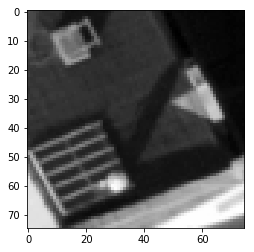

In [24]:
plt.imshow(gray_images[1][:,:, 0], cmap='gray')

In [50]:
gray_features = get_features_for(gray_images)
gray_features.shape

(120, 75, 75, 36)

In [51]:
gray_pixel_features = gray_features.reshape(120*75*75, gray_features.shape[-1])
gray_pixel_features.shape

(675000, 36)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gray_pixel_features, pixel_masks, test_size = 0.20)

In [60]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tim/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     92156
         255       0.91      0.86      0.88     42844

   micro avg       0.93      0.93      0.93    135000
   macro avg       0.92      0.91      0.92    135000
weighted avg       0.93      0.93      0.93    135000

accuracy=0.9285481481481481
[[88613  3543]
 [ 6103 36741]]


In [62]:
ac_gray_images = np.array([cv.cvtColor(image.astype(np.float32), cv.COLOR_BGR2GRAY).reshape(image.shape[0], image.shape[1], 1) for image in train[0:50]])

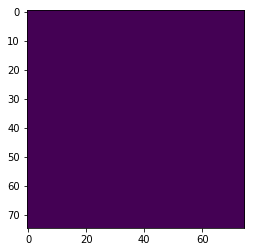

In [63]:
ac_im_features = get_features_for([ac_gray_images[8]])
ac_im_features = ac_im_features.reshape(75*75, 36)

im_pred = clf.predict(ac_im_features)
prediction_image = im_pred.reshape(75, 75)

plt.imshow(prediction_image)